<h1 style="font-family: Trebuchet MS; font-size: 14px; color: #720026; text-align: right; ">**Matthew Liew**</h1>
<h1><br><span style="color: #720026;; font-size: 40px"><b>Entrix: Case Study Challenge</b></span><br></h1>

**Table of Contents**:

* [Question 1](#Q1)
   1. [Data Discovery](#discovery)
   2. [ARIMA](#ARIMA)
   3. [Prophet](#Prophet)
   4. [XGBoost](#XGBoost)
   5. [Backtesting: Forecast Models](#Backtesting_Forecast)
   6. [Q1 Analysis Conclusion](#q1_conclusion)
* [Question 2](#Q2)
  1. [Problem Formulation](#problem)
  2. [Implementation: CVXPY](#opt_implementation)
  3. [Backtesting: Optimization](#backtest_opt)
  4. [Q2 Conclusion](#q2_con)
* [Question 3](#6)
  1. [Setup](#setup)
  2. [Training Strategy](#training)
  3. [Q3 Conclusion](#q3_con)


In [1]:
# load necessary packages

import warnings
from datetime import datetime, timedelta

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Time series and stats
from darts import TimeSeries
from darts.utils.statistics import (
    check_seasonality, plot_acf, plot_pacf,
    remove_seasonality, remove_trend,
    stationarity_test_adf, extract_trend_and_seasonality
)
from darts.utils.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine learning & metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from prophet import Prophet
import cvxpy as cp

# External data sources
from meteostat import Point, Hourly
import holidays
import yfinance as yf

# Custom utilities and wrappers
import data_utils as du
import plotters
from forecast_utils import ARIMAWrapper, XGBWrapper, ProphetWrapper, SARIMAXWrapper
from backtesting import BacktestXGB, BacktestProphet, BacktestARIMA


# To keep track of the RSME and MAE metrics
forecast_metric_long = {}
forecast_metric_short = {}
warnings.simplefilter(action='ignore', category=FutureWarning)

<a id="Q1"></a>

<p style="background-color:#ff7f51;font-family:Trebuchet MS;font-weight:bold;color:#FFFFFF ;font-size:40px;text-align:center;border-radius:100px 100px">Question 1</p>




<a id="discovery"></a>

<p style="background-color:rgb(0, 87, 114);font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">Data Discovery</p>

In [2]:
# load data set

day_price_df = pd.read_csv('./data/Day-ahead_Prices_60min.csv')

# split the date column into start and end time, we will use start time only
day_price_df[['start_time', 'end_time']] = day_price_df['MTU (CET/CEST)']\
                                                .str.split(' - ', expand=True)

# drops unnecessary columns
day_price_df.drop(columns=['MTU (CET/CEST)', 'BZN|DE-LU', 'Currency', 'end_time']
                , inplace=True) # assumes all currency same in same region

day_price_df.rename(columns={
    'Day-ahead Price [EUR/MWh]': 'price'
}, inplace=True)

day_price_df['start_time'] = pd.to_datetime(day_price_df['start_time'],
                                            format='%d.%m.%Y %H:%M')
day_price_ts = day_price_df.set_index('start_time') 

px.line(day_price_ts, title='Day-Ahead Price Time Series (EUR/MWh) - hourly')

<a id="0"></a>

# <h1 style="font-family: Trebuchet MS; font-size: 25px; color: #da627d; text-align: left; "><b>Data Cleaning</b></h1>

In this section, we'll focus on data cleaning, specifically checking for any NaN values. If any are found, we'll examine the corresponding dates and determine whether we can fill the missing value using interpolation, back fill or front fill.

In [3]:
idx_nan = day_price_df['price'].isna()
print(f"There exists {idx_nan.sum()} missing values")

# prints missing value with 5 rows before and after
day_price_df[idx_nan]
missing_row = du.show_nrows_around_target(day_price_df, 'price')
missing_row = pd.DataFrame(missing_row).set_index('start_time')
px.line(missing_row, title="Shows missing value(s)")

There exists 1 missing values


We identified one missing value occurring at 2AM CET. Given the time, it's unlikely to be an outlier or exhibit extreme variation, so it's reasonable to interpolate this value.


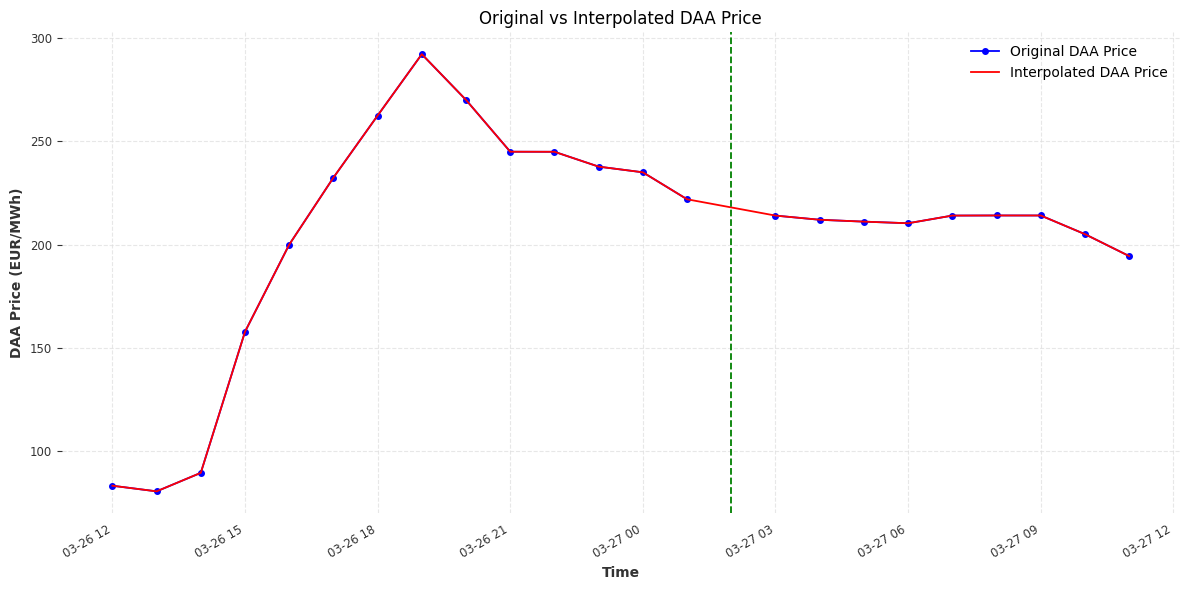

In [4]:
day_price_ts['price_interpolated'] = day_price_ts['price'].interpolate(method='time')

# Analysis
start_date = datetime(2022, 3, 26, 12)
end_date = datetime(2022, 3, 27, 12)
filtered_data = day_price_ts[['price', 'price_interpolated']].loc[
    (day_price_ts.index >= start_date) & (day_price_ts.index < end_date)
]
plt.figure(figsize=(12, 6))
plt.plot(filtered_data.index, filtered_data['price'], 'b-o', label='Original DAA Price', markersize=4)
plt.plot(filtered_data.index, filtered_data['price_interpolated'], 'r-', label='Interpolated DAA Price')
plt.title('Original vs Interpolated DAA Price')
plt.xlabel('Time')
plt.ylabel('DAA Price (EUR/MWh)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

vertical_line_time = datetime(2022, 3, 27, 2)  # vertical line for missing value
plt.axvline(x=vertical_line_time, color='green', linestyle='--', label='02:00')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [5]:
# replaces interpolated price with original price
day_price_ts['price'] = day_price_ts['price_interpolated']
day_price_ts.drop(columns=['price_interpolated'], inplace=True)
day_price_ts.head()

price
start_time                
2022-01-01 00:00:00  50.05
2022-01-01 01:00:00  41.33
2022-01-01 02:00:00  43.22
2022-01-01 03:00:00  45.46
2022-01-01 04:00:00  37.67

<a id="0"></a>

# <h1 style="font-family: Trebuchet MS; font-size: 25px; color: #da627d; text-align: left; "><b>Preliminary Analysis</b></h1>

Now that we have a complete time series dataset, we can perform a preliminary analysis to inspect the time series data

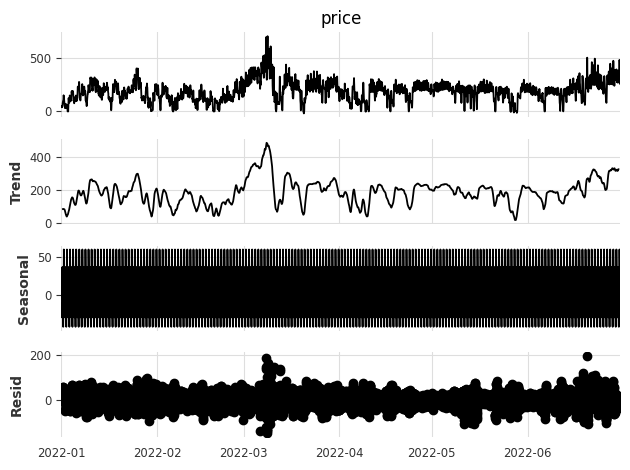

In [6]:
# Seasonal decomposition

seasonal_decompose(day_price_ts['price']).plot()
plt.show()

The seasonal decomposition of the price time series reveals a clear upward trend with a noticeable disturbance around early March 2022, this is likely caused by **Russia invasion of Ukraine**. Furthermore, towards the end, there appears to be slight upward trend.

The seasonal component shows regular periodic behavior, likely due to daily or hourly cycles. 

The residuals remain relatively stable throughout most of the period, there is increased variability and notable outliers around the same March period, aligning with the observed spike.

This suggests that perhaps one may use ARIMA or ETS to model the time series.

<a id="ARIMA"></a>
<p style="background-color: rgb(0, 87, 114);font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">ARIMA</p>

ARIMA(p,d,q) is a combinaation of Autogressive model AR(p), Moving Average model MA(q) with differenciating parameter d where $(p,d,q) \in \mathbb{N} \times \mathbb{N} \times \mathbb{N}$. Given a time series $Y_t$ for all $t\in(t,\dots,T)$, the models can be defined as follows

- Autoregressive, AR(p)
    $$ 
    Y_t = c + \sum_{i=1}^{p} \phi_i Y_{t-i} + \epsilon_t 
    $$,

where $c, \phi \in \mathbb{R}$ and $\epsilon_t$ is residual distributed by $N(0, \sigma^2)$

- Moving Average: MA(q)

$$ Y_t = c + \epsilon_t + \sum_{i=1}^{q} \theta_i \epsilon_{t-i} $$

- Differencing term

$$ Y_t^d := (1-B)^d Y_t,$$

where $B$ is backward operator, i.e. $BY_t = Y_{t-1}$.

Thereforem, ARIMA(p,d,q) is modeled as

$$
    Y_t^d = c + \sum_{t=1}^{p} \phi_i Y_{t-i}^d + \sum_{t=1}^{q} \theta_i \epsilon_{t-i} + \epsilon_t,
$$
where c is some constant and $\phi_t$ and $\theta_t$ are parameters to be calculated.

<span style="color:rgb(80, 9, 195);">**Assumptions**</span>:
- $Y_t^d$ is stationary or has been differenced to achieve stationarity, i.e. constant mean, variance, and autocorrelation,
- Linear relationship,
- $\epsilon_t$ is residual distributed by $\mathcal{N}(0, \sigma^2)$ and not autocorrelation.

**Pros**

- ARIMA models most of time series data with trends, cycles, seasonality, and beyond as long as it's stationary,
- Handles missing values,
- Has good statistical metrics (i.e. coefficients, std, p-values, AIC) for analysis and forecast purposes.

**Cons**

- Need time series to be stationary - if not unable to handle longer forecast,
- Cannot hand nonlinear models.

To begin analsysis, we will split that data. First, we will attempt approx 70/30 split of the time series to evaluate its performance. Then, we will shorten the test window, as one can see later, ARIMA is unable to handle long term forecast, but does well in a shorter term e.g. 24 H. 

Stationarity test for whole series with 0 lag:
Reject the null hypothesis. The series is likely stationary.

Train-Test split at 2022-06-01 00:00:00
Stationarity test for train series with 0 lag:
Reject the null hypothesis. The series is likely stationary.



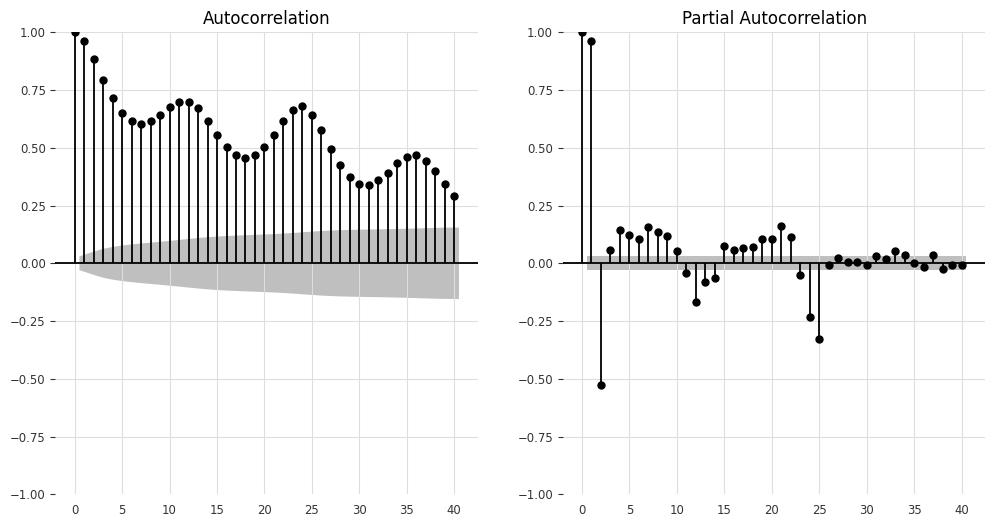

In [7]:
split_date = datetime(2022, 6, 1)
arima_obj = ARIMAWrapper(day_price_ts, split_date)

# First, we check the stationary test and plot the ACF and PACF for the full time series
arima_obj.plot_acf_pacf() 

### Note:

we find the best (p,d,q) parameters for ARIMA using the training data. We do this by traversing (p,d,q) with different integers and get the one with the smalles AIC value.

In [8]:
# %%capture 
# p,d,q = arima_obj.get_best_ARIMA_params()
# print(f"Best params obtain: ARIMA({p}, {d}, {q})")

# # Best params obtain: ARIMA(5, 1, 3)

In [9]:
arima_obj.fit_model(5, 1, 3)
arima_obj.get_forecast()
arima_obj.plot_forecast()
forecast_metric_long['ARIMA'] = list(arima_obj.get_rmse_mae())

--------------------------------
Running ARIMA(5, 1, 3) on train set


c:\Users\MX98OL\Desktop\ALM\Projects\entrix_assessment\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

c:\Users\MX98OL\Desktop\ALM\Projects\entrix_assessment\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

c:\Users\MX98OL\Desktop\ALM\Projects\entrix_assessment\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

c:\Users\MX98OL\Desktop\ALM\Projects\entrix_assessment\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\MX98OL\Desktop\ALM\Projects\entrix_assessment\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 3625
Model:                 ARIMA(5, 1, 3)   Log Likelihood              -15734.424
Date:                Mon, 26 May 2025   AIC                          31486.848
Time:                        14:26:38   BIC                          31542.606
Sample:                    01-01-2022   HQIC                         31506.712
                         - 06-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0838      0.088     12.248      0.000       0.910       1.257
ar.L2          0.3084      0.180      1.714      0.087      -0.044       0.661
ar.L3         -1.1098      0.145     -7.630      0.0

c:\Users\MX98OL\Desktop\ALM\Projects\entrix_assessment\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



RSME for ARIMA(5, 1, 3): 80.866
MAE for ARIMA(5, 1, 3): 65.131


### Note

From the analysis above, it is clear that ARIMA is not able to forecast too far in advance. Note that in the summary table tells us that although the residual is not autocorrelated by Ljung-Box test, it is not normally distributed by Jarque-Bera test. Therefore this is not suitable to be used as a forecast.


Since we are interested in 24H forecast window from assumption,so in the following we only want to forecast **24 H** on the day of 30. June 2022 and we take the training from 60 days prior for training.

Stationarity test for whole series with 0 lag:
Reject the null hypothesis. The series is likely stationary.

Train-Test split at 2022-06-29 23:00:00
Stationarity test for train series with 0 lag:
Reject the null hypothesis. The series is likely stationary.



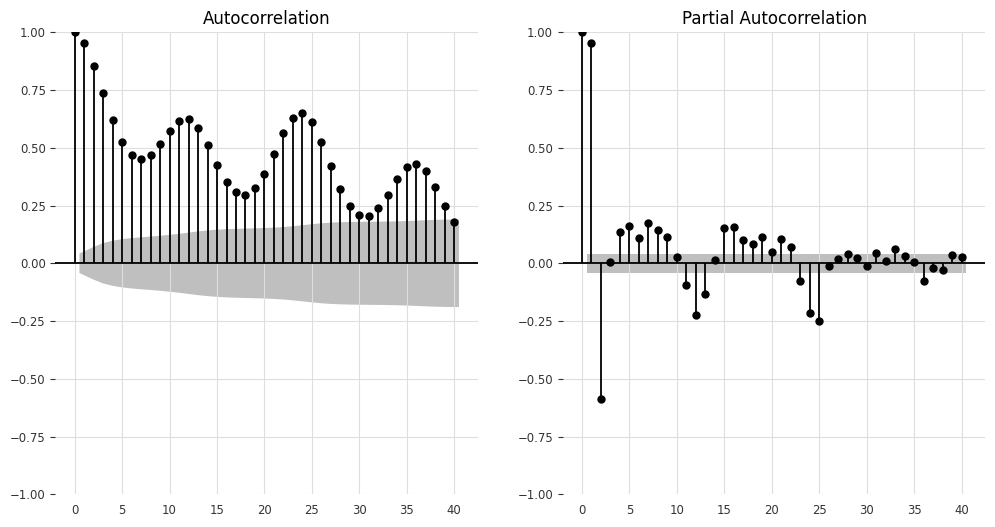

In [10]:
short_split_date = datetime(2022, 6, 29, 23) 
start_slice = split_date - timedelta(days=60) 

short_arima = ARIMAWrapper(day_price_ts, short_split_date, start_date_slice=start_slice)
short_arima.plot_acf_pacf()

In [11]:
# check stationary test for one lag

ts_short = TimeSeries.from_dataframe(short_arima.ts)
ts_train_short = TimeSeries.from_dataframe(short_arima.ts_train)

print(stationarity_test_adf(ts_short, 1))
print("--"*20)
print(stationarity_test_adf(ts_train_short, 1))

# So we should take d = 1

(np.float64(-13.969798268748544), np.float64(4.3660887578950485e-26), 1, 2158, {'1%': np.float64(-3.4333838718977896), '5%': np.float64(-2.8628802551435264), '10%': np.float64(-2.567483485481099)}, np.float64(18841.985495389694))
----------------------------------------
(np.float64(-14.024070151788049), np.float64(3.5290145424763366e-26), 1, 2134, {'1%': np.float64(-3.433418033468612), '5%': np.float64(-2.862895338734693), '10%': np.float64(-2.567491516545175)}, np.float64(18586.92304034924))


In [12]:
# %%capture 
# p,d,q = short_arima.get_best_ARIMA_params()

# print(f"Best params obtain: ARIMA({p}, {d}, {q})")

# # Best params obtain: ARIMA(3, 1, 4)

In [13]:
short_arima.fit_model(3, 1, 4)
short_arima.get_forecast()
short_arima.plot_forecast(title = f'Day-ahead Price [EUR/MWh] - 24H Predicted with ARIMA(3,1,4)')
forecast_metric_short['ARIMA'] = list(short_arima.get_rmse_mae())

--------------------------------
Running ARIMA(3, 1, 4) on train set


c:\Users\MX98OL\Desktop\ALM\Projects\entrix_assessment\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

c:\Users\MX98OL\Desktop\ALM\Projects\entrix_assessment\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

c:\Users\MX98OL\Desktop\ALM\Projects\entrix_assessment\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

c:\Users\MX98OL\Desktop\ALM\Projects\entrix_assessment\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 2136
Model:                 ARIMA(3, 1, 4)   Log Likelihood               -9030.666
Date:                Mon, 26 May 2025   AIC                          18077.331
Time:                        14:26:42   BIC                          18122.661
Sample:                    04-02-2022   HQIC                         18093.920
                         - 06-29-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7415      0.044     16.678      0.000       0.654       0.829
ar.L2          0.7156      0.077      9.296      0.000       0.565       0.867
ar.L3         -0.9905      0.044    -22.282      0.0

c:\Users\MX98OL\Desktop\ALM\Projects\entrix_assessment\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



RSME for ARIMA(3, 1, 4): 68.443
MAE for ARIMA(3, 1, 4): 57.868


In [14]:
short_arima.fit_model(3, 1, 4)
short_arima.get_forecast()
short_arima.plot_forecast(title = f'Day-ahead Price [EUR/MWh] - 24H Predicted with ARIMA(3,1,4)')
forecast_metric_short['ARIMA'] = list(short_arima.get_rmse_mae())

c:\Users\MX98OL\Desktop\ALM\Projects\entrix_assessment\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

c:\Users\MX98OL\Desktop\ALM\Projects\entrix_assessment\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

c:\Users\MX98OL\Desktop\ALM\Projects\entrix_assessment\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.



--------------------------------
Running ARIMA(3, 1, 4) on train set


c:\Users\MX98OL\Desktop\ALM\Projects\entrix_assessment\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 2136
Model:                 ARIMA(3, 1, 4)   Log Likelihood               -9030.666
Date:                Mon, 26 May 2025   AIC                          18077.331
Time:                        14:26:44   BIC                          18122.661
Sample:                    04-02-2022   HQIC                         18093.920
                         - 06-29-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7415      0.044     16.678      0.000       0.654       0.829
ar.L2          0.7156      0.077      9.296      0.000       0.565       0.867
ar.L3         -0.9905      0.044    -22.282      0.0

c:\Users\MX98OL\Desktop\ALM\Projects\entrix_assessment\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



RSME for ARIMA(3, 1, 4): 68.443
MAE for ARIMA(3, 1, 4): 57.868


# SARIMA

In [15]:
short_split_date = datetime(2022, 6, 29, 23) 
start_slice = split_date - timedelta(days=60) 

short_sarimax = SARIMAXWrapper(
                            ts=day_price_ts,
                            split_point=short_split_date,
                            start_date_slice=start_slice,
                            order=(3, 1, 4),
                            seasonal_order=(1, 1, 1, 24))
short_sarimax.fit_model()
short_sarimax.get_forecast()
short_sarimax.plot_forecast(title = f'Day-ahead Price [EUR/MWh] - 24H Predicted with SARIMAX(3,1,4)(1,1,1,24)')
# forecast_metric_short['ARIMA'] = 
list(short_arima.get_rmse_mae())

c:\Users\MX98OL\Desktop\ALM\Projects\entrix_assessment\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

c:\Users\MX98OL\Desktop\ALM\Projects\entrix_assessment\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.



Stationarity test for whole series with 0 lag:
Reject the null hypothesis. The series is likely stationary.

Train-Test split at 2022-06-29 23:00:00
Stationarity test for train series with 0 lag:
Reject the null hypothesis. The series is likely stationary.

--------------------------------
Running SARIMAX((3, 1, 4)) on train set


c:\Users\MX98OL\Desktop\ALM\Projects\entrix_assessment\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                      SARIMAX Results                                       
Dep. Variable:                                price   No. Observations:                 2136
Model:             SARIMAX(3, 1, 4)x(1, 1, [1], 24)   Log Likelihood               -8670.705
Date:                              Mon, 26 May 2025   AIC                          17361.410
Time:                                      14:27:13   BIC                          17417.960
Sample:                                  04-02-2022   HQIC                         17382.117
                                       - 06-29-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3986      0.143      2.782      0.005       0.118       0.680
ar.L2          0.89

c:\Users\MX98OL\Desktop\ALM\Projects\entrix_assessment\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



--------------------------------
Forecasting 24 steps ahead


RSME for ARIMA(3, 1, 4): 68.443
MAE for ARIMA(3, 1, 4): 57.868


[np.float64(68.443), 57.868]

<a id="Prophet"></a>
<p style="background-color:rgb(0, 87, 114);font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">Prophet</p>

A forcasting tool by Facebook:

$$
Y_t = g_t + s_t + h_t + \epsilon_t,
$$

where
- $Y_t$ is the predicted value,
- $g_t$ trend function,
- $s_t$ weekly/year seasonality,
- $h_t$ represents the effects of holidays or any other irregular days,
- $\epsilon_t$ represents the error term.

**Pros**

- Easy "out of the box" solution,
- Detects trend automatically,
- Can handle missing data and outliers.

**Cons**
- Black box,
- Difficulty to tune hyperparameters.


In [17]:
# Reuse the data and split_date from ARIMA for longer window forecast

prophet_obj = ProphetWrapper(
                day_price_ts,
                split_date,
                )
prophet_obj.run_prophet()
prophet_forecast = prophet_obj.get_forecast()

Train-Test split at 2022-06-01 00:00:00


14:23:09 - cmdstanpy - INFO - Chain [1] start processing
14:23:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet model fitted. Use get_forecast() to get forecast.


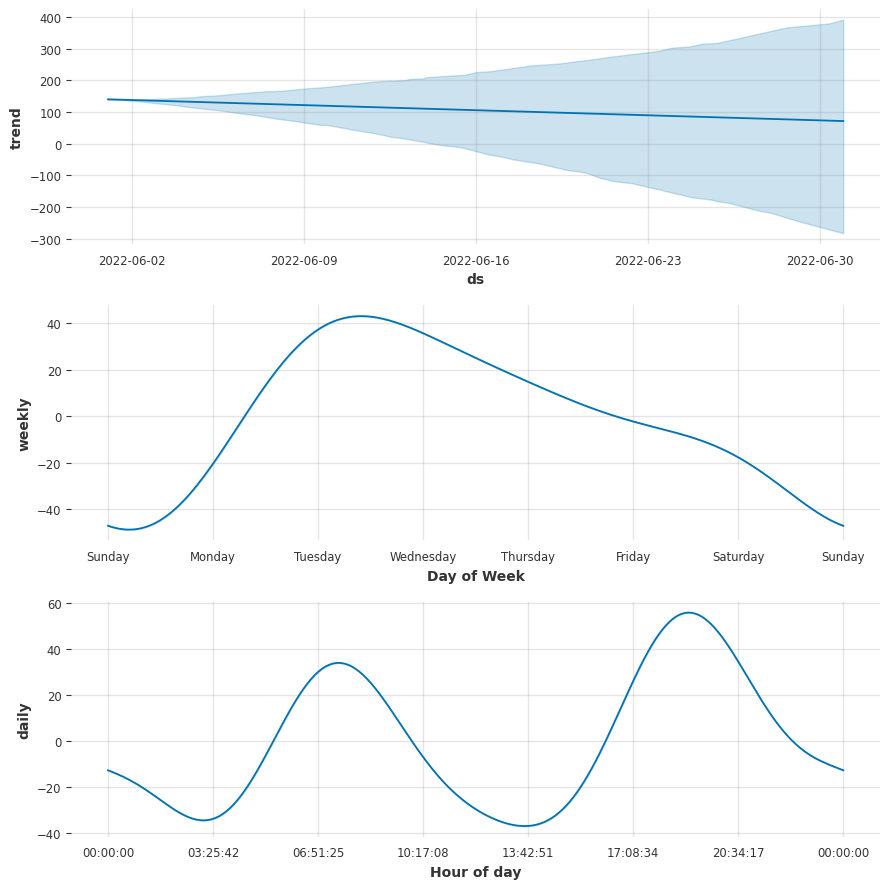

In [18]:
prophet_obj.prophet_model.plot_components(prophet_forecast)
plt.show()
prophet_obj.plot_forecast()

In [19]:
forecast_metric_long['Prophet'] = list(prophet_obj.get_rmse_mae())

RSME for Prophet: 140.083
MAE for Prophet: 115.47


#### **Shorter training window and forecast only 24 H**

Like ARIMA, we also observed that the Prophet model does not do so well in a longer term in our data possibily due to non-starionarity. Therefore, we can inspect its efficacy in the short time window: 24H

Train-Test split at 2022-06-29 23:00:00


14:23:11 - cmdstanpy - INFO - Chain [1] start processing
14:23:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet model fitted. Use get_forecast() to get forecast.


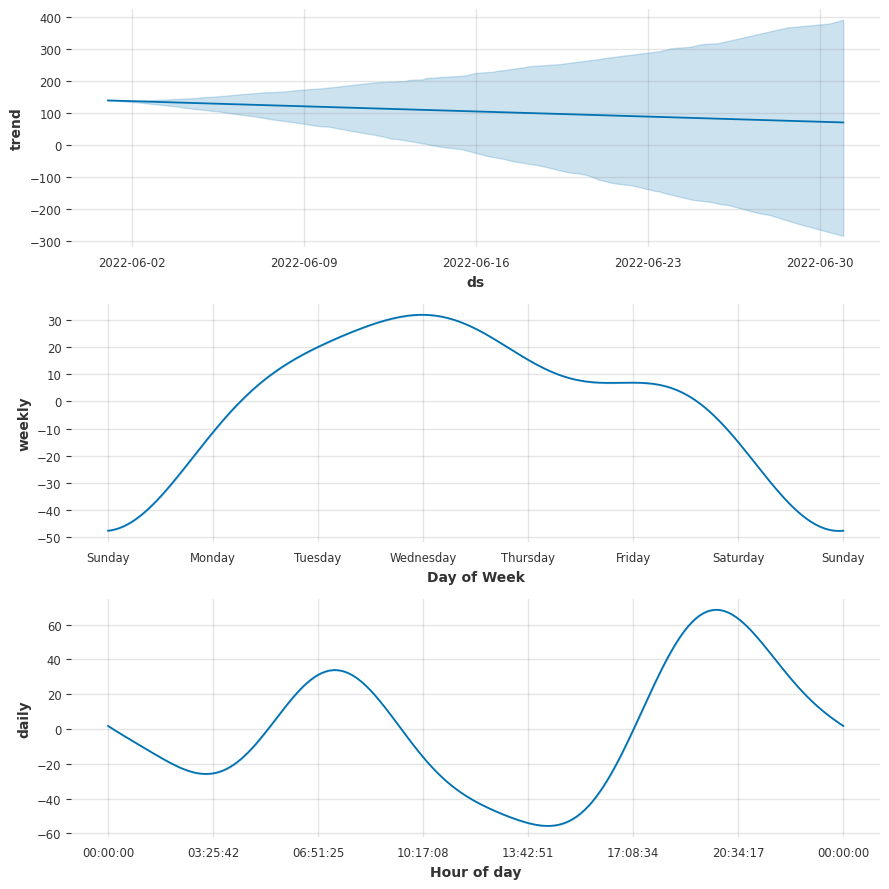

In [20]:
short_date_24H = datetime(2022, 6, 29, 23)
start_slice = split_date - timedelta(days=60) 

short_prophet_obj = ProphetWrapper(
                day_price_ts,
                short_split_date,
                start_date_slice=start_slice
                )
short_prophet_obj.run_prophet()
short_prophet_forecast = short_prophet_obj.get_forecast()
short_prophet_obj.prophet_model.plot_components(prophet_forecast)
plt.show()
short_prophet_obj.plot_forecast()

In [21]:
print("RSME and MAE for short term Prophet:")
forecast_metric_short['Prophet'] = list(short_prophet_obj.get_rmse_mae())

RSME and MAE for short term Prophet:
RSME for Prophet: 39.666
MAE for Prophet: 30.506


<a id="XGBoost"></a>
<p style="background-color:rgb(0, 87, 114);font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">XGBoost</p>

“Extreme Gradient Boosting” (XGBoost) is used for supervised learning problems, where we use the training data (with multiple features) to predict a target variable, here the DAA Price. The model uses gradient boosting to build ensemble of decision trees where at each tree aims to minimize the error made by previous tree.

 <span style="color: #F8766D;">**Assumptions**</span>
As the model is nonparametric, it can capture complex relationship in the data. Therefore the assumptions here are made as we explains features we are going to use.

**Pros**
 - Better performance as we will see later than ARIMA and Prophet,
 - It is easy to adjust the features to be selected and XGBoost package will generate which feature is the most important, explaining a certain aspect of the modeling.

**Cons*
- overfitting could happen, especially with high n-estimators. However, since for this usecase, this is not much of a concern,
- the trees generated is hugh, it is not easy to have a complete picture of the forecasting decision compared to, for e.g., ARIMA where you can see the coefficient,
- estimators might not be the same for each run unless seed is set.

<a id="Feature"></a>

## <span style="color: #F8766D;">**Feature Selection**</span>


We loaded an hourly time-series with DAA price per MWh. We start feature engineering by separating the the datetime into its atomic metrics, i.e. month of the year, week of the year, day of the week, and the hour of day. On top of that, we will also extract boolean features such as is_weekend, is_holiday.

We will do this by calling `add_date_features()` function. 

In [22]:
xgb_day_price_ts = du.add_date_features(day_price_ts.copy())

xgb_day_price_ts.head()

price  is_weekend            datetime  hour  dayofweek  \
start_time                                                                    
2022-01-01 00:00:00  50.05        True 2022-01-01 00:00:00     0          5   
2022-01-01 01:00:00  41.33        True 2022-01-01 01:00:00     1          5   
2022-01-01 02:00:00  43.22        True 2022-01-01 02:00:00     2          5   
2022-01-01 03:00:00  45.46        True 2022-01-01 03:00:00     3          5   
2022-01-01 04:00:00  37.67        True 2022-01-01 04:00:00     4          5   

                     quarter  year  dayofyear  dayofmonth  month  weekofyear  \
start_time                                                                     
2022-01-01 00:00:00        1  2022          1           1      1          52   
2022-01-01 01:00:00        1  2022          1           1      1          52   
2022-01-01 02:00:00        1  2022          1           1      1          52   
2022-01-01 03:00:00        1  2022          1           1      1          52   
2022-01-01 04:00:00        1  2022          1           1      1          52   

                     is_holiday  
start_time                       
2022-01-01 00:00:00       False  
2022-01-01 01:00:00       False  
2022-01-01 02:00:00       False  
2022-01-01 03:00:00       False  
2022-01-01 04:00:00       False

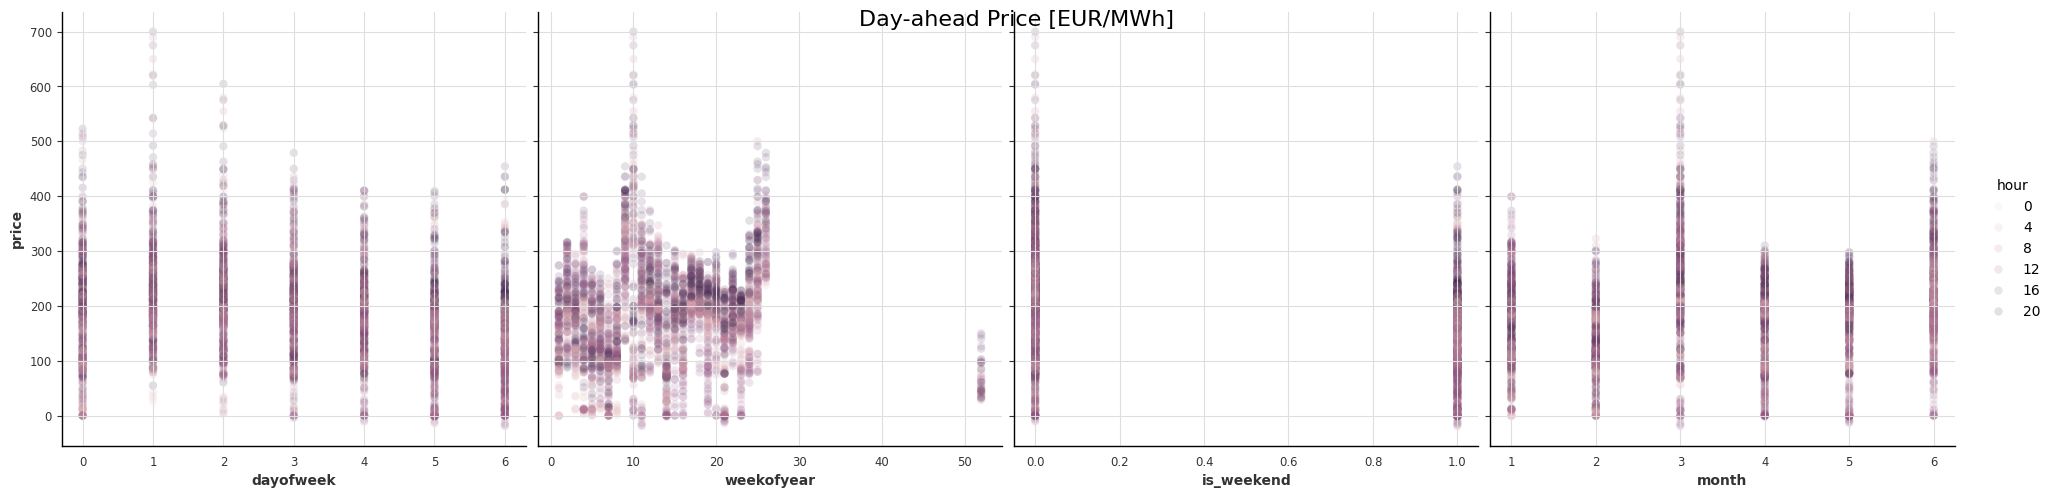

In [23]:
sns.pairplot(xgb_day_price_ts,
            hue='hour',
            x_vars=['dayofweek','weekofyear', 'is_weekend', 'month'],
            y_vars='price',
            height=5,
            plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Day-ahead Price [EUR/MWh]', fontsize=16)
plt.show()

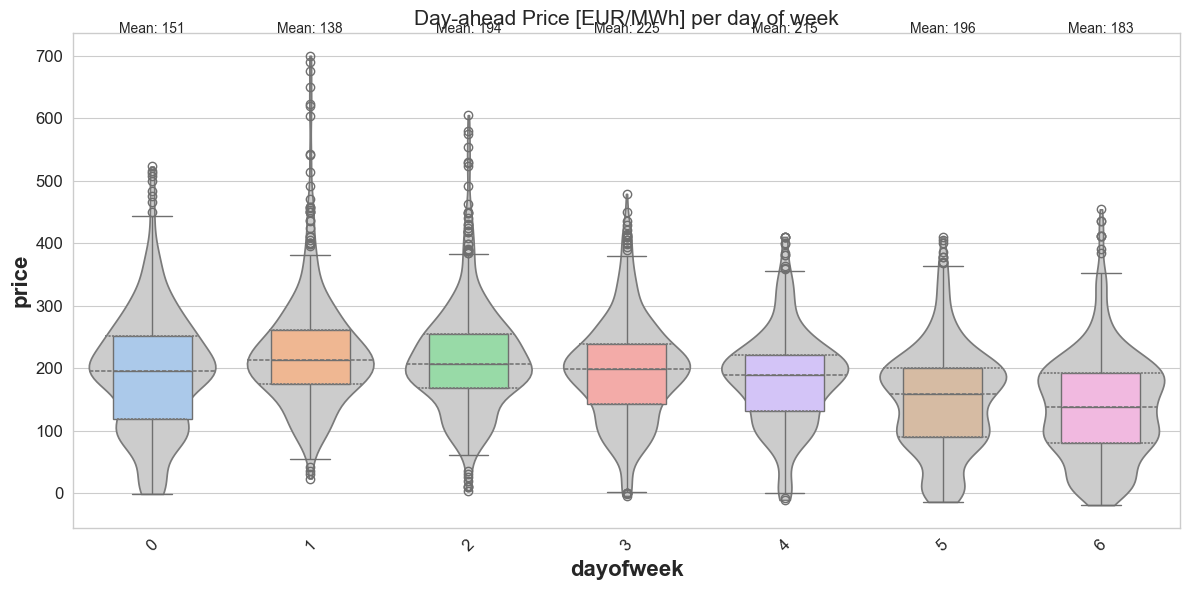

In [24]:
plotters.plot_violin_ts(xgb_day_price_ts, 'dayofweek', 'price', 'Day-ahead Price [EUR/MWh] per day of week')

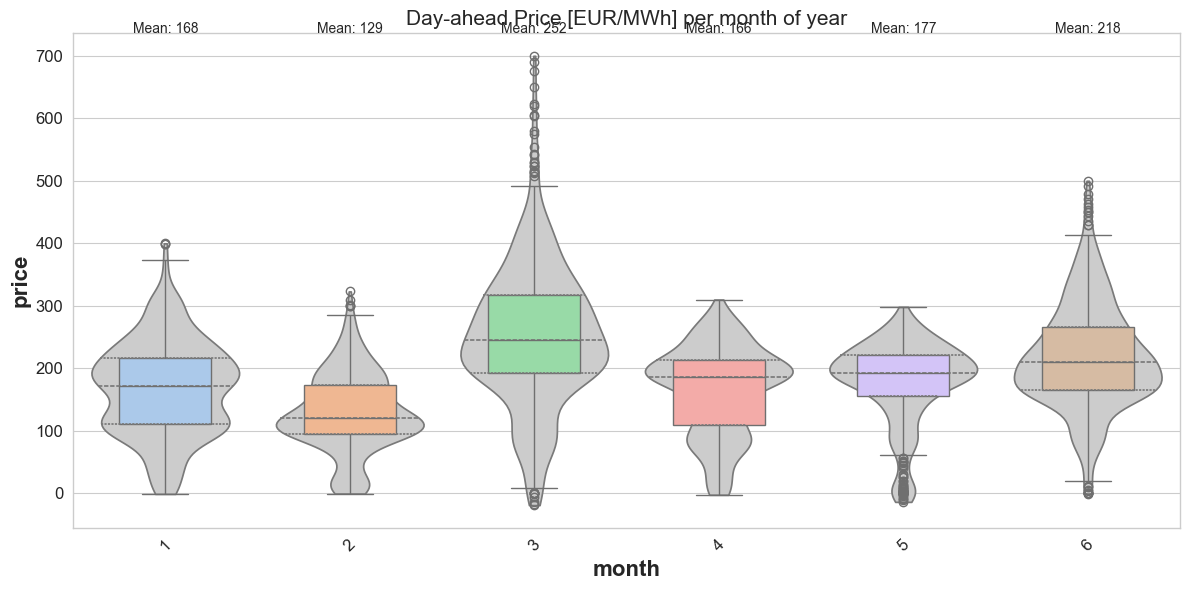

In [25]:
plotters.plot_violin_ts(xgb_day_price_ts, 'month', 'price', 'Day-ahead Price [EUR/MWh] per month of year')

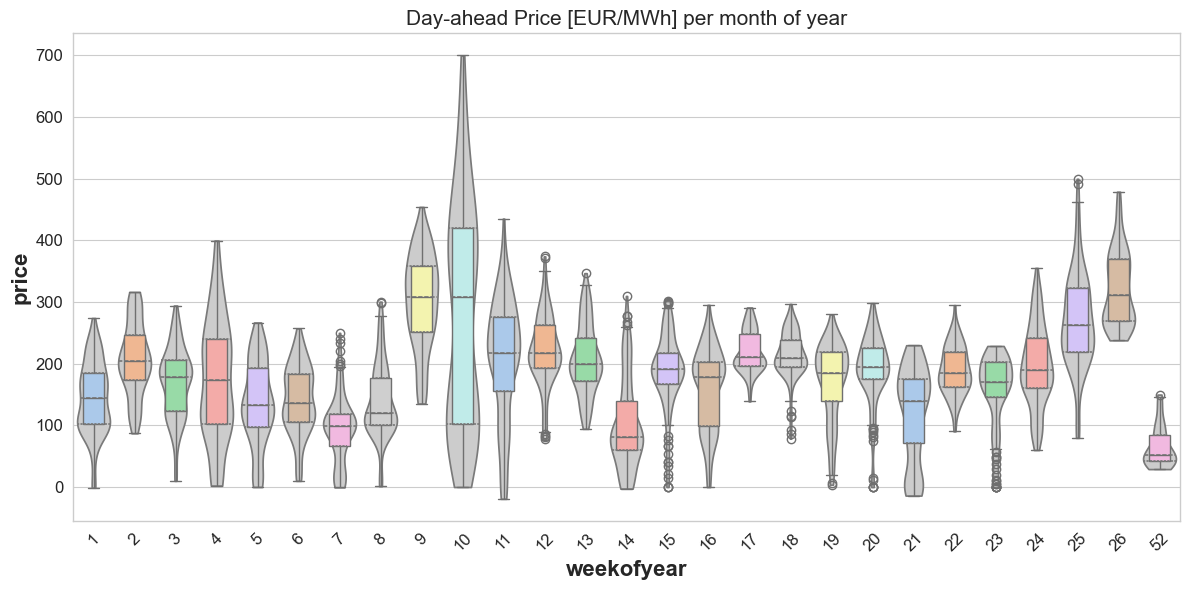

In [26]:
plotters.plot_violin_ts(xgb_day_price_ts, 'weekofyear', 'price', 'Day-ahead Price [EUR/MWh] per month of year', False)

### <span style="color: #F8766D;">**Weather Data**</span>

Weather data is incredible useful to us because from the demand side. For example, temperature and sunlight time might directly affect the expected demand of the electricity, thus pushing up the DAA price. On supply side, depending on how the electricity is priced, a predicted high wind and sunny days might mean the production of electricity is expected to be high, thus increasing the expected supply of electricity decreasing the DAA price.

Of course, some of these weather data might actually be captured by the time information such as month of the year already. However, given the situation of increasingly unpredictable weather pattern due to climate change, feature engineering on weather data is getting increasingly important.

In [27]:
locations = {
    'LU': (49.815273, 6.129583),  # Luxembourg City coordinates
    'DE': (52.520008, 13.404954)  # Berlin coordinates (as an example for Germany)
}

# add mean weather data that is available from meteostat package
weather_data = du.add_locations_weather(xgb_day_price_ts, locations) 

xgb_merged_data = xgb_day_price_ts.merge(
    weather_data[['temp', 'tsun']], # get only temperature and sunshine data
    left_index=True,
    right_index=True,
    how='left'
    )

xgb_merged_data.head()

price  is_weekend            datetime  hour  dayofweek  \
start_time                                                                    
2022-01-01 00:00:00  50.05        True 2022-01-01 00:00:00     0          5   
2022-01-01 01:00:00  41.33        True 2022-01-01 01:00:00     1          5   
2022-01-01 02:00:00  43.22        True 2022-01-01 02:00:00     2          5   
2022-01-01 03:00:00  45.46        True 2022-01-01 03:00:00     3          5   
2022-01-01 04:00:00  37.67        True 2022-01-01 04:00:00     4          5   

                     quarter  year  dayofyear  dayofmonth  month  weekofyear  \
start_time                                                                     
2022-01-01 00:00:00        1  2022          1           1      1          52   
2022-01-01 01:00:00        1  2022          1           1      1          52   
2022-01-01 02:00:00        1  2022          1           1      1          52   
2022-01-01 03:00:00        1  2022          1           1      1          52   
2022-01-01 04:00:00        1  2022          1           1      1          52   

                     is_holiday  temp  tsun  
start_time                                   
2022-01-01 00:00:00       False  11.9   0.0  
2022-01-01 01:00:00       False  11.9   0.0  
2022-01-01 02:00:00       False  11.9   0.0  
2022-01-01 03:00:00       False  11.9   0.0  
2022-01-01 04:00:00       False  11.8   0.0

### <span style="color: #F8766D;">**How to capture economic sentiment?**</span>

As we can see in March 2022, there was a spike in DAA Price. At that time, it was the invasion of Ukraine by Russia, a major exporter of energy to Europe esp. Germany. To capture this, we will use the Volatility Index (VIX) as well as the german stock market index (DAX). 

VIX measures the volatilty of options market. It's often referred to as the "fear index" because it tends to spike during times of financial stress or market uncertainty. While DAX is a stock market index that represents 30 of the largest and most liquid publicly traded companies in Germany, listed in the Frankfurt Stock Exchange.

Moreover, we would also include the currency exchange rate between EUR and USD, the latter which most denominated currencies for trades.

Note here the data available to us is daily. Therefore, we will use the closing price of previous day as part of our features.

In [28]:
indices = ['^VIX', '^GDAXI', 'EURUSD=X']

vix_close = yf.download('^VIX',
                        start=xgb_merged_data.index.min() - timedelta(days=1),
                        end=xgb_merged_data.index.max()
                        )['Close']
dax_close = yf.download('^GDAXI',
                        start=xgb_merged_data.index.min() - timedelta(days=1),
                        end=xgb_merged_data.index.max()
                        )['Close']
eur_usd_close = yf.download("EURUSD=X",
                            start=xgb_merged_data.index.min() - timedelta(days=1),
                            end=xgb_merged_data.index.max()
                            )['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [29]:
# Shift the indices by 1 day
vix_close['^VIX'] = vix_close['^VIX'].shift(1)
dax_close['^GDAXI'] = dax_close['^GDAXI'].shift(1)
eur_usd_close['EURUSD=X'] = eur_usd_close['EURUSD=X'].shift(1)

# drop the irrevelant date
vix_close = vix_close.loc[vix_close.index >= datetime(2022, 1, 1)]
dax_close = dax_close.loc[dax_close.index >= datetime(2022, 1, 1)]
eur_usd_close = eur_usd_close.loc[eur_usd_close.index >= datetime(2022, 1, 1)]

vix_close.sort_index(inplace=True)
dax_close.sort_index(inplace=True)
eur_usd_close.sort_index(inplace=True)

In [30]:
xgb_merged_data['date'] = xgb_merged_data['datetime'].dt.date

vix_close['date'] = vix_close.index.date
dax_close['date'] = dax_close.index.date
eur_usd_close['date'] = eur_usd_close.index.date

xgb_merged_data = xgb_merged_data.merge(
                                vix_close[['date', '^VIX']], 
                                on='date', 
                                how='left'
                                )

xgb_merged_data = xgb_merged_data.merge(
                                dax_close[['date', '^GDAXI']], 
                                on='date', 
                                how='left'
                                )

xgb_merged_data = xgb_merged_data.merge(
                                eur_usd_close[['date', 'EURUSD=X']], 
                                on='date', 
                                how='left'
                                )

xgb_merged_data.set_index(xgb_merged_data['date'], inplace=True)

xgb_merged_data = xgb_merged_data.rename(
                                        columns={'^VIX': 'VIX',
                                        '^GDAXI': 'DAX',
                                        'EURUSD=X': 'EURUSD'}
                                        )


xgb_merged_data.drop(['date'], axis=1, inplace=True)
xgb_merged_data = xgb_merged_data.set_index(xgb_merged_data['datetime'])

In [31]:
plotters.plot_compare_two_col(xgb_merged_data, 'price', 'VIX', 'Day-ahead Price [EUR/MWh] vs VIX')

In [32]:
plotters.plot_compare_two_col(xgb_merged_data, 'price', 'DAX', 'Day-ahead Price [EUR/MWh] vs DAX')

In [33]:
plotters.plot_compare_two_col(xgb_merged_data, 'price', 'EURUSD', 'Day-ahead Price [EUR/MWh] vs EUR/USD Exchange Rate')

### <span style="color: #F8766D;">**Energy Market**</span>

Another feature to consider adding is incorporating additional data from the DE/LU market. Specifically, we can include variables such as grid load, residual load, and day-ahead generation.

 - Grid load: total electricity demand on the power grid at any given time, reflecting how much energy consumers are using. 
 - Residual load: difference between the total demand and the electricity supplied by renewable sources like wind and solar; it indicates the amount of electricity that must be provided by conventional power plants or other sources to maintain grid stability. 
 - Day-ahead generation: forecasted electricity production scheduled for the next day, based on market bids and planned generation. This variable is chosen instead of actual generation because we <span style="color: #F8766D;">**assume**</span>  actual realized demand and supply is already priced in.
- energy balance: measures the gap between supply and demand on the grid. 

Note here that, like in financial indicies, we <span style="color: #F8766D;">**assume**</span> that only the data of one hour prior given a time point is available to us, i.e. at 1pm start time, we only know the data up to 12pm-1pm. Therefore, we need to take 1-lag of the data.

The data are obtained from SMARD.

In [34]:
df_load = pd.read_csv('./data/Actual_consumption_202112310000_202207010000_Hour.csv',
                        delimiter=';', parse_dates=['Start date', 'End date'])

df_load = df_load.drop(columns=['End date'])
df_load = df_load.rename(columns={'grid load [MWh] Calculated resolutions': 'grid_load',
                                    'Residual load [MWh] Calculated resolutions': 'residual_load',})

# obtain grid load
df_load['grid_load'].loc[df_load['grid_load']=='-'] = np.nan
df_load['grid_load'] = df_load['residual_load'].shift(1)
df_load['grid_load'] = df_load['grid_load'].str.replace(',', '').astype(float)


# obtain residual load
df_load['residual_load'].loc[df_load['residual_load']=='-'] = np.nan # replace missing values properly
df_load['residual_load'] = df_load['residual_load'].shift(1)
df_load['residual_load'] = df_load['residual_load'].str.replace(',', '').astype(float)

df_load = df_load.set_index('Start date')
df_load.index.name = 'datetime'
df_load = df_load.loc[df_load.index >= datetime(2022, 1, 1)]
df_load.sort_index(inplace=True)


C:\Users\MX98OL\AppData\Local\Temp\ipykernel_12340\2514074313.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\MX98OL\AppData\Local\Temp\ipykernel_12340\2514074313.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\MX98OL\AppData\Local\Temp\ipykernel_12340\2514074313.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [35]:
df_DH_generation = pd.read_csv('./data/Forecasted_generation_Day-Ahead_202112310000_202207010000_Hour.csv',
                        delimiter=';', parse_dates=['Start date', 'End date'])

df_DH_generation = df_DH_generation.set_index('Start date')
df_DH_generation.index.name = 'datetime'

df_DH_generation= df_DH_generation[['Total [MWh] Original resolutions']]
df_DH_generation = df_DH_generation.rename(columns={'Total [MWh] Original resolutions': 'total_DH_generation'})
df_DH_generation['total_DH_generation'] = df_DH_generation['total_DH_generation'].shift(1)
df_DH_generation['total_DH_generation'] = df_DH_generation['total_DH_generation']\
                                            .str.replace(',', '').astype(float)

# drops the previous day data
df_DH_generation = df_DH_generation.loc[df_DH_generation.index >= datetime(2022, 1, 1)]
df_DH_generation.sort_index(inplace=True)



C:\Users\MX98OL\AppData\Local\Temp\ipykernel_12340\2546593148.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [36]:
# join all the energery market data
xgb_merged_data = xgb_merged_data.join(df_load[['grid_load', 'residual_load']], how='left')\
                                    .join(df_DH_generation[['total_DH_generation']], how='left')



In [37]:
xgb_merged_data['energy_balance'] = xgb_merged_data['total_DH_generation'] - xgb_merged_data['grid_load']

### Covariance Matrices

In the following, we will generate a covariance matrix to examine the relationships between features. This helps us identify whether certain features move together (positive or negative correlation), which can provide insight into multicollinearity or potential feature redundancies.

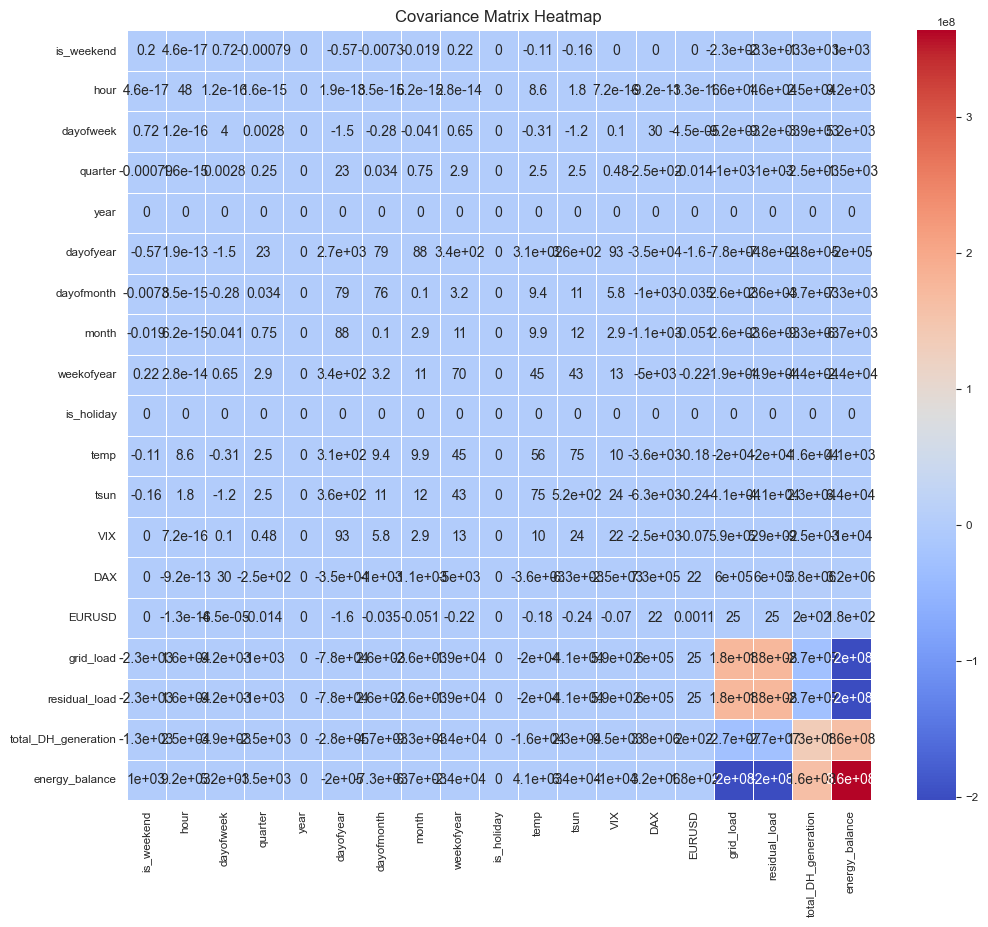

In [38]:
plt.figure(figsize=(12, 10))
sns.heatmap(
            xgb_merged_data.reset_index(drop=True).drop(
                ['price', 'datetime'],
                axis=1
                ).cov(),
            annot=True,
            cmap='coolwarm',
            linewidths=0.5
            )
plt.title('Covariance Matrix Heatmap')
plt.show()

From the table above, we can see that energy balance while having high variance has also non-trivial covariance with features related to the energy load. This was to be expected as it was merely the difference between DA generation and grid load. Between grid load and residual load, it also espected they have some correlation by definition.

We could use PCA analysis to run, but as the feature is not managable, we will instead use XGBoost feature later to see which features are the most important

In [39]:
drop_col = [
            # 'price_ma_3d',
            # 'temp',
            # 'EURUSD',
            'quarter',
            # 'is_weekend',
            # 'is_holiday',
            ]

cleaned_merged_data = xgb_merged_data.copy().drop(drop_col, axis=1)


#### **Run XGBoost**

In [40]:
split_date = datetime(2022, 5, 1)
xgb_obj = XGBWrapper(cleaned_merged_data.copy(), split_point=split_date)

Train-Test split at 2022-05-01 00:00:00


### <span style="color: #F8766D;">**Lagged target variables as features**</span>

Time series data often has autocorrelation, meaning past values can provide useful information about future values. As we will <span style="color:rgb(179, 40, 221);">**prevent data leakage**</span> that everyday at 0:00 hour, we want to make the prediction for the next 24 hours. Therefore, we will mimick this effect and assumming at a given day, we will forecast the DA Price based on the previous day time at the same hour.

So we want to also include the previous lagged price data into our feature. However, to <span style="color:rgb(221, 52, 40);">prevent data leakage</span>, we will also add this column after train-text data has been split. 


Here we will use the following lagged variable and rolling mean:

In [41]:
xgb_obj.add_lagged_MA_price(hours=[24])


xgb_obj.add_lagged_MA_price(hours=[24, 36, 48], rolling_mean=True)




Adding n-lagged hour of price to X_train and X_test
Adding mean of previous 24 hours of price to X_train and X_test [Rolling Mean]
Adding n-lagged hour of price to X_train and X_test
Adding mean of previous 24 hours of price to X_train and X_test
Adding mean of previous 24 hours of price to X_train and X_test [Rolling Mean]
Adding mean of previous 36 hours of price to X_train and X_test
Adding mean of previous 36 hours of price to X_train and X_test [Rolling Mean]
Adding mean of previous 48 hours of price to X_train and X_test
Adding mean of previous 48 hours of price to X_train and X_test [Rolling Mean]


XGBoost model initialized with seed 11 and None trees.
XGBoost model fitted.


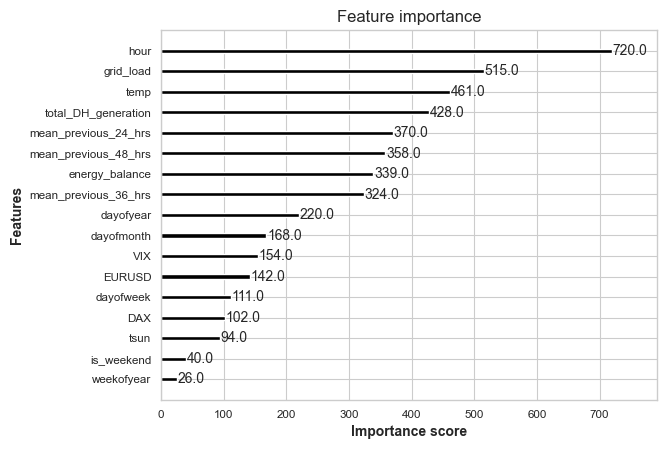

In [42]:
xgb_obj.run_xgb()
xgb_obj.plot_importance

In [43]:
xgb_obj.get_forecast()
xgb_obj.plot_forecast()
forecast_metric_long['XGBoost'] = list(xgb_obj.get_rmse_mae())


RSME for XGBoost: 36.383
MAE for XGBoost: 26.577


#### **Short forecast window: 24**

Training data = 60 days from the split datetime

Train-Test split at 2022-06-29 23:00:00
Adding n-lagged hour of price to X_train and X_test
Adding mean of previous 4 hours of price to X_train and X_test [Rolling Mean]
Adding mean of previous 24 hours of price to X_train and X_test [Rolling Mean]
Adding mean of previous 48 hours of price to X_train and X_test [Rolling Mean]
Adding mean of previous 72 hours of price to X_train and X_test [Rolling Mean]
XGBoost model initialized with seed 11 and None trees.
XGBoost model fitted.


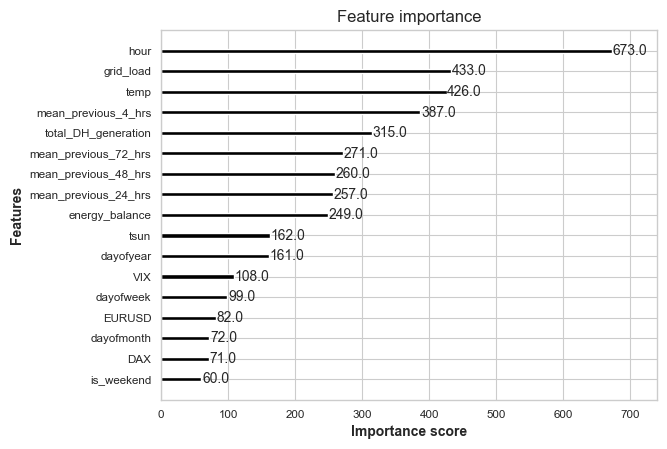

RSME for XGBoost: 43.553
MAE for XGBoost: 34.288
RMSE for XGBoost last 24 H: 43.553
MAE for XGBoost last 24 H: 34.288


In [44]:
start_slice = short_split_date - timedelta(days=60) 
short_xgb_obj = XGBWrapper(
                cleaned_merged_data.copy(),
                short_split_date,
                start_date_slice=start_slice
                )
short_xgb_obj.add_lagged_MA_price(hours=4, days=3)
short_xgb_obj.run_xgb()
short_xgb_obj.plot_importance
short_xgb_obj.get_forecast()
short_xgb_obj.plot_forecast()
forecast_metric_short['XGBoost'] = list(short_xgb_obj.get_rmse_mae())
xgb_rsme_24H, xgb_mae_24H = du.get_rmse_mae(
                                short_xgb_obj.y_test[-24:],
                                short_xgb_obj.get_forecast_df['price_prediction'][-24:]
                                )

forecast_metric_short['XGBoost'] = [xgb_rsme_24H, xgb_mae_24H]

print(f"RMSE for XGBoost last 24 H: {xgb_rsme_24H}")
print(f"MAE for XGBoost last 24 H: {xgb_mae_24H}")

<a id="Backtesting_Forecast"></a>
<p style="background-color:rgb(0, 87, 114);font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">Backtesting: Forecast Models</p>

Backtesting for time series is the process of evaluating a forecasting model by simulating how it would perform on historical data. This is also known as **Walk Forward Validation**

The data is split into training and testing periods: the model is trained on past observations (e.g., the previous 45 days) and then used to predict future values (e.g., the next 24 hours), which are compared to the actual outcomes. 

This process is repeated across multiple time windows to assess the model’s accuracy and generalization over time. Backtesting helps identify overfitting, validate model robustness, and select the best forecasting approach for real-world deployment.

In [45]:
# Get a list of split dates for backtesting
split_dates = []
forecast_window = 24
train_data_days = 45
# Example: if 2022-04-02 00:00:00 is chosen as split date,
# train data starts at 2022-02-16 00:00:00 and 
# test data ends at 2022-04-03 00:00:00

back_test_df = day_price_df.copy()

for n in range(train_data_days*24 + forecast_window, len(back_test_df), train_data_days*24 + forecast_window):
    m = n - forecast_window
    split_datetime = pd.to_datetime(back_test_df.iloc[m]['start_time'])
    split_dates.append(split_datetime)

In [46]:
split_dates

[Timestamp('2022-02-15 00:00:00'),
 Timestamp('2022-04-02 00:00:00'),
 Timestamp('2022-05-18 00:00:00')]

In [47]:
# %%capture
# supresses ouput
# Backtest XGBoost

window_xgb_rsme = []
window_xgb_mae = []
window_xgb_forecast: list[pd.DataFrame] = []

for split in split_dates:
    backtest_xgb = BacktestXGB(cleaned_merged_data,
                split,
                n_backward=train_data_days,
                forecast_window=forecast_window)
    rsme, mae =backtest_xgb.get_windowed_rsme_mae()
    window_xgb_rsme.append(rsme)
    window_xgb_mae.append(mae)
    backtest_xgb.plot_forecast()

    window_xgb_forecast.append(backtest_xgb.get_windowed_forecast())

Running XGBoost: starting at 2022-01-01 00:00:00
ending at 2022-02-16 00:00:00
Train-Test split at 2022-02-15 00:00:00
Adding n-lagged hour of price to X_train and X_test
Adding mean of previous 4 hours of price to X_train and X_test [Rolling Mean]
Adding mean of previous 24 hours of price to X_train and X_test [Rolling Mean]
Adding mean of previous 48 hours of price to X_train and X_test [Rolling Mean]
Adding mean of previous 72 hours of price to X_train and X_test [Rolling Mean]
XGBoost model initialized with seed 11 and None trees.
XGBoost model fitted.
RSME for XGBoost: 19.746
MAE for XGBoost: 15.605


Running XGBoost: starting at 2022-02-16 00:00:00
ending at 2022-04-03 00:00:00
Train-Test split at 2022-04-02 00:00:00
Adding n-lagged hour of price to X_train and X_test
Adding mean of previous 4 hours of price to X_train and X_test [Rolling Mean]
Adding mean of previous 24 hours of price to X_train and X_test [Rolling Mean]
Adding mean of previous 48 hours of price to X_train and X_test [Rolling Mean]
Adding mean of previous 72 hours of price to X_train and X_test [Rolling Mean]
XGBoost model initialized with seed 11 and None trees.
XGBoost model fitted.
RSME for XGBoost: 98.952
MAE for XGBoost: 94.085


Running XGBoost: starting at 2022-04-03 00:00:00
ending at 2022-05-19 00:00:00
Train-Test split at 2022-05-18 00:00:00
Adding n-lagged hour of price to X_train and X_test
Adding mean of previous 4 hours of price to X_train and X_test [Rolling Mean]
Adding mean of previous 24 hours of price to X_train and X_test [Rolling Mean]
Adding mean of previous 48 hours of price to X_train and X_test [Rolling Mean]
Adding mean of previous 72 hours of price to X_train and X_test [Rolling Mean]
XGBoost model initialized with seed 11 and None trees.
XGBoost model fitted.
RSME for XGBoost: 11.944
MAE for XGBoost: 9.752


In [48]:
%%capture
# supresses ouput
# Backtest XGBoost

window_prophet_rsme = []
window_prophet_mae = []

for split in split_dates:
    backtest_prophet = BacktestProphet(cleaned_merged_data,
                split,
                n_backward=train_data_days,
                forecast_window=forecast_window)
    rsme, mae =backtest_prophet.get_windowed_rsme_mae()
    window_prophet_rsme.append(rsme)
    window_prophet_mae.append(mae)


14:23:22 - cmdstanpy - INFO - Chain [1] start processing
14:23:22 - cmdstanpy - INFO - Chain [1] done processing
14:23:22 - cmdstanpy - INFO - Chain [1] start processing
14:23:23 - cmdstanpy - INFO - Chain [1] done processing
14:23:23 - cmdstanpy - INFO - Chain [1] start processing
14:23:23 - cmdstanpy - INFO - Chain [1] done processing


In [49]:
%%capture
# Backtest ARIMA

window_ARIMA_rsme = []
window_ARIMA_mae = []

for split in split_dates:
    backtest_ARIMA = BacktestARIMA(day_price_ts,
                split,
                n_backward=train_data_days,
                forecast_window=forecast_window)
    rsme, mae =backtest_ARIMA.get_windowed_rsme_mae()
    window_ARIMA_rsme.append(rsme)
    window_ARIMA_mae.append(mae)

AttributeError: 'ARIMAWrapper' object has no attribute 'run_ARIMA'

In [50]:
# aggregate results and the mean for the RSME and MAE from the backtesting

forecast_metric_window = {}

forecast_metric_window['ARIMA'] = [np.mean(window_ARIMA_rsme), np.mean(window_ARIMA_mae)]
forecast_metric_window['Prophet'] = [np.mean(window_prophet_rsme), np.mean(window_prophet_mae)]
forecast_metric_window['XGBoost'] = [np.mean(window_xgb_rsme), np.mean(window_xgb_mae)]

c:\Users\MX98OL\Desktop\ALM\Projects\entrix_assessment\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning:

Mean of empty slice.

c:\Users\MX98OL\Desktop\ALM\Projects\entrix_assessment\.venv\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning:

invalid value encountered in scalar divide



<a id="q1_conclusion"></a>

<p style="background-color:rgb(0, 87, 114);font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">Q1 Analysis Conclusion</p>

A common method to evaluate the performance of forecasting models is to look at the error metrics, RMSE and MAE. Denote $y_i$ and $\hat{y}_i$ as the target and predicated value, here it the DAA price and predicted DAA price, where $i \in \{1,\dots,N\}$. Then, RSME and MAE are defined as:

-  Root Mean Squared Error (RMSE)
$$
\text{RMSE} = \sqrt{ \frac{1}{N} \sum_{i=1}^{N} \left( y_i - \hat{y}_i \right)^2 }.
$$

RMSE gives more weight to larger errors, so it's more sensitive to outliers in the data.


- Mean Absolute Error (MAE)
$$
\text{MAE} = \frac{1}{N} \sum_{i=1}^{N} \left| y_i - \hat{y}_i \right|
$$
MAE is easy to interpret and treats all errors equally, regardless of their magnitude.

Rule of thumb is, we want the smaller values of RSME and/or MAE and these values. As sanity check, these values should be lower than the mean and std of the time series.

Now, let's look at the RSME and MAE of the models


In [51]:
du.print_rmse_mae_table(forecast_metric_long, "RMSE and MAE table for Models - Complete Evaluation, split at 2022-05-01")
du.print_rmse_mae_table(forecast_metric_short, "RMSE and MAE table for Models - 24H Evaluation")


RMSE and MAE table for Models - Complete Evaluation, split at 2022-05-01
+---------+---------+----------+
| Model   |    RMSE |      MAE |
+=========+=========+==========+
| ARIMA   |  80.866 |  65.131  |
+---------+---------+----------+
| Prophet | 140.083 | 115.47   |
+---------+---------+----------+
| XGBoost |  36.383 |  26.5769 |
+---------+---------+----------+
------------------------------------------------------------
RMSE and MAE table for Models - 24H Evaluation
+---------+--------+--------+
| Model   |   RMSE |    MAE |
+=========+========+========+
| ARIMA   | 68.443 | 57.868 |
+---------+--------+--------+
| Prophet | 39.666 | 30.506 |
+---------+--------+--------+
| XGBoost | 43.553 | 34.288 |
+---------+--------+--------+
------------------------------------------------------------


In [52]:
du.print_rmse_mae_table(forecast_metric_window, "RMSE and MAE table for Models - Backtesting")

RMSE and MAE table for Models - Backtesting
+---------+----------+----------+
| Model   |     RMSE |      MAE |
+=========+==========+==========+
| ARIMA   | nan      | nan      |
+---------+----------+----------+
| Prophet |  34.3307 |  28.7063 |
+---------+----------+----------+
| XGBoost |  43.5471 |  39.814  |
+---------+----------+----------+
------------------------------------------------------------


As shown in the table generated above, XGBoost demonstrates the lowest overall RMSE and MAE, outperforming both ARIMA and Prophet, in longer forecast window.

This is expected as XGBoost used more feature engineering and ARIMA & Prophet are univariate time series models. These traditional models struggle with long-term forecasting, with Prophet performing worst amongst the 3 models. However, when the training and testing window is shortened, both ARIMA and Prophet show improved RMSE and MAE values—though still not as low as those achieved by XGBoost.

In the short forecast window, however, we see Prophet shines in that it was less RMSE and MAE than XGBoost and ARIMA.

As for forward rolling (backtesting), for a given window (61 days, 60 days train, 1 day forcast), we find that XGBoost performs better than ARIMA and Prophet.

As for stability, XGBoost might be different from each run if seed is not set. This changes is especially noticeable in the shorter forecast window.

In terms of runtime, the difference seems to be insignificant given the data we obtained. However, for our usecase, we did not need a large n-estimator.However, a caveat for ARIMA is that the ACF plot does not give a clear picture of what parameters to be picked in ARIMA($p,d,q$). Therefore, an optimization was carried out to find the optimized $(p,d,q)$. This can be time consuming. For XGBoost, the higher the n-estimators, the longer that it will take. For Prophet, its runtime is negligible. 

In consideration an weighting the performance of the models in terms of backtesting metrics, we will <span style="color:rgb(17, 142, 6);">**choose XGBoost**</span> going forward to Question 2 (Q2) as the the backtesting metrics suggests that it is more resilient and robust.

### <span style="color: #F8766D;">**Limitations and Improvements**</span>

One way to improve the analysis is by incorporating backtesting. Backtesting simulates how a forecasting model would have performed in the past by repeatedly training and testing it on different rolling windows of historical data. This way we can get a more complete metrics when evaluating the model.

This helps assess the model’s stability and generalization across time. Implementation typically includes splitting the dataset into multiple train-test splits, sliding the window forward for time series, and keep forecasting metrics at each step. 

Another potential model that can be considered in the future is the use of neural network such as Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) networks, which are designed to handle sequential data by maintaining information over time steps. However, they also have limitation in a way that the global minima might not be reached or the runtime would take too long for larger data. Another idea is Feature Forcast Moving Average (FFORMA), developed by Prof. Hyndman, a meta-learning model that considers several weighted forecasting models based on feature-based machine learning ("meta-learning) to improve overall predictive performance.

In [53]:
# # pickle dump fitted XGBoost for forcasting short window (24H)
# with open('xgb_model_fitted.pkl', 'wb') as f:
#     pickle.dump(xgb_obj.model, f)

In [54]:
# xgb_obj.predicted_XGBoost.to_csv('./data/xgb_forecasted_price.csv')

<a id="Q2"></a>
<p style="background-color:#ff7f51;font-family:Trebuchet MS;font-weight:bold;color:#FFFFFF ;font-size:40px;text-align:center;border-radius:100px 100px">Question 2</p>



<a id="problem"></a>

<p style="background-color:#720026;font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">Problem Formulation</p>

So we have predicted the price in our previous question. Now, we want to make use of the predictions in order to maximize profit by charging and discharging our battery. We are given the following environment variables:

 - DAA Price (EUR/MWh) predicted by the XGBoost
 - A battery that can charge and discharge 1 MW per hour and has capacity of 1MWh 
 - <span style="color:rgb(20, 95, 12);">**Aim**</span>: to make the strategy when to charge and discharge in time span of last 24H available in dataset (i.e. 30. June 2022)

<span style="color:rgb(80, 9, 195);">**Assumptions**</span>:

1. battery starts at capacity of 0
2. battery charge and discharge is instantaneous and incurs no transaction cost
3. battery does not degrade overtime
4. Energy market is open and always have supply for the battery to charge
5. At the beginning of the day, the strategy of charge/discharge is decided and set for the day

**Remark**: one can think about this as buying a stock in the stock market where one person can buy or sell a homogenous stock given a period of time. The act of charging, would be buying a stock from the market and vice versa.

First, we define the denote the objective function by
    $$
    \sum_{t=0}^T p(t) [- a(t)],
    $$
where $p(t)$ is the price at time $t$ and $a(t) \in [-1, 1, 0]$ is the action to charge/discharge at hourly time $t \in [0,\dots,T]$ (here $T=23$). In particular, the action space is given by
$$
a(t) =
\begin{cases}
1,\quad & \text{charge},\\
0, & \text{do nothing},\\
-1, & \text{discharge},
\end{cases}
$$
for all $t \in (1\dots,T)$

**Note** that in the objective function, the negative sign on the $a(t)$ is because as one discharges, $a(t) = -1$ and one earns profit, therefore it has to be negated.

Recall our aim is
    $$
    \max_{\phi(a)} \sum_{t=0}^T p(t) [- a(t)],
    $$
where $\phi(a) = (a(t))_{t=0}^T$ is schedule of charge/discharge.

Now we will formulate our constraints as follows:

1. The battery cannot be charged or discharged (action) beyond its maximum rate, here 1 MHh:

   $$
   |a(t)| \leq 1.
   $$

2. Denote $b(t)$ to be the charge level of the battery at time $t$, its capacity can be represented by

   $$
   0 \leq b(t) \leq 1.
   $$

3. Recall we assumed we start with empty battery

    $$
    b(0) = 0.
    $$

4. To represent the physical fact that if we have an empty battery, we cannot discharge and that we must charged sometime earlier in order to discharge it later in time:
   
    $$
    \begin{align*}
    b(t) & = b(t-1) + a(t-1)
    \\
    & = b(t-2) + a(t-2) + a(t-1)
    \\
    & \vdots
    \\
    & = b(0) + \sum_{i=0}^{t-1} a(i)
    \\
    & = \sum_{i=0}^{t-1} a(i).
    \end{align*}
    $$

**Well-posedness of the problem**: Finally, we show that solution exists. Since our objective function is linear and, most importantly, that all the variable parameters (convex cone) above are closed and bounded (i.e. compact). Then, by Weierstrass Theorem, there must exist a unique maximum and minimum. Hence, the solution to the optimization problem exists and unique, and therefore well-defined.

<a id="opt_implementation"></a>

<p style="background-color: #720026;font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">Implementation: CVXPY</p>

In [55]:
# load the forecasted price by XGBoost in Q1
forecasted_df = xgb_obj.predicted_XGBoost.copy()

plotters.plotly_actual_predict(
                        forecasted_df,
                        'price',
                        'price_prediction',
                        title='Recall: Day-ahead Price [EUR/MWh] Predicted with XGBoost'
                        )

In [56]:
# # Uncomment if want to use Prophet

# prophet = short_prophet_obj.ts[['ds', 'y']].copy()
# prophet = prophet.merge(short_prophet_obj.forecasted_df, on='ds', how='left')
# prophet.set_index('ds', inplace=True)
# forecasted_df = prophet.rename(columns={'y': 'price', 'yhat': 'price_prediction'})
# plotters.plotly_actual_predict(
#                         forecasted_df,
#                         'price',
#                         'price_prediction',
#                         title='Recall: Day-ahead Price [EUR/MWh] Predicted with Prophet'
#                         )

In [57]:
# limits the scope to last 24H
df_24H = forecasted_df['price_prediction'][-24:]
predicted_array = df_24H.to_numpy() 

In [58]:
# Env parameters
def opt_battery_problem(
        predicted_array: np.ndarray,
        battery_capa: int = 1,
        max_charge_discharge: int = 1
        ) -> tuple[cp.Problem, np.ndarray, np.ndarray]:
    
    n = len(predicted_array)

    # define the optimization variables
    charge_discharge = cp.Variable(n)   # a(t)
    state_of_charge = cp.Variable(n)    # s(t)

    # constraints
    constraints = [
        state_of_charge[0] == 0,                    # Initial state of charge
        state_of_charge <= battery_capa,            # Battery capacity limit
        charge_discharge >= -max_charge_discharge,  # Maximum discharge rate
        charge_discharge <= max_charge_discharge,   # Maximum charge rate
        state_of_charge >= 0,                       # Battery cannot be negative
        state_of_charge[1:] == cp.cumsum(charge_discharge[:-1]),  # State of charge evolution
    ]

    # objective function
    objective = cp.Maximize(cp.sum(cp.multiply(predicted_array, -charge_discharge)))
    return cp.Problem(objective, constraints), charge_discharge, state_of_charge

In [59]:
# solve the problem
problem_obj_24H, charge_discharge, state_of_charge = opt_battery_problem(predicted_array)
problem_obj_24H.solve()

print(f"Maximum predicted profit: {round(problem_obj_24H.value,2)}")
print(f"Optimized charge/discharge schedule, phi(a): {np.round(charge_discharge.value)}")
print(f"State of charge at each time step, s(t): {np.round(state_of_charge.value)}")

Maximum predicted profit: 561.47
Optimized charge/discharge schedule, phi(a): [ 0.  0. -0.  1. -0.  0.  0. -0. -1. -0. -0.  0. -0.  0.  1.  0.  0. -0.
 -0. -1.  0.  0. -0. -1.]
State of charge at each time step, s(t): [ 0.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.
  1.  1.  0.  0.  0. -0.]


In [60]:
px.line(x = df_24H.index,
        y=charge_discharge.value,
        title="Optimized schedule for charge/discharge, \u03A6(a(t))")

In [61]:
px.line(x = df_24H.index,
        y=state_of_charge.value,
        title="Battery State, b(t)")

<span style="color:rgb(76, 45, 214);">**Note**</span>: Here we have obtained just the predicted profit according to the predicted pirce XGBoost modeled. To find the actual profit, we will need to compare with the real price with the strategy $\phi(a(t))$ we have optimized.

In [62]:
# load the real data
df_24H_actual = forecasted_df['price'][-24:]
df_24H_actual = df_24H_actual.to_numpy()

actual_profit = np.sum(- df_24H_actual * charge_discharge.value)
print(f"Actual profit: {round(actual_profit,2)}")

Actual profit: 560.64


#### <span style="color: #F8766D;">**Perfect Foresight**</span>

Let's first evaluate how much profit we would make if we knew the price in perfect foresight.


In [63]:
# solve the problem
problem_obj_act, charge_discharge_act, state_of_charge_act = opt_battery_problem(df_24H_actual)
problem_obj_act.solve()

print(f"Perfect foresight: Maximum profit: {round(problem_obj_act.value,2)}")
print(f"Perfect foresight: Optimized charge/discharge schedule, phi(a): {np.round(charge_discharge_act.value)}")
print(f"Perfect foresight: State of charge at each time step, s(t): {np.round(state_of_charge_act.value)}")

Perfect foresight: Maximum profit: 587.83
Perfect foresight: Optimized charge/discharge schedule, phi(a): [ 0.  1. -0. -1.  1.  0. -0. -0. -1. -0.  0.  1. -1.  1.  0.  0.  0. -0.
  0. -1. -0.  0. -0. -1.]
Perfect foresight: State of charge at each time step, s(t): [ 0.  0.  1.  1.  0.  1.  1.  1.  1.  0.  0.  0.  1.  0.  1.  1.  1.  1.
  1.  1.  0.  0.  0. -0.]


#### <span style="color: #F8766D;">**How did XGBoost + CVXPY do?**</span>

In [64]:
act_profit = round(actual_profit,2)
perc_gain = round(((problem_obj_act.value - actual_profit) / problem_obj_act.value) * 100,2)

msg = f"As shown above, we were able to get (average) profit of {round(actual_profit,2)} Euro with predicted price from XGBoost and optimization from CVXPY."
msg += f"\nIf we have perfect foresight, we would have earn about {perc_gain}% more."

print(msg)

As shown above, we were able to get (average) profit of 560.64 Euro with predicted price from XGBoost and optimization from CVXPY.
If we have perfect foresight, we would have earn about 4.63% more.


<a id="backtest_opt"></a>
<p style="background-color:#720026;font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">Backtesting: Optimization</p>

In [65]:
from scipy.stats import hmean
print(f"we will use the following {str(split_dates)}")

backtest_proft_act = []
backtest_profit_foresight = []

for df in window_xgb_forecast:

    print(start_date, end_date)
    # get charge discharge schedule from forecasted price
    predicted_array = df['price_prediction'].to_numpy()
    problem_obj_window, charge_discharge, state_of_charge = opt_battery_problem(predicted_array)
    problem_obj_window.solve()
    backtest_proft_act.append(problem_obj_24H.value)

    actual_array = df['price'].to_numpy()

    # calculate profit from the schedule from forecasted price
    actual_profit_pred = np.sum(- actual_array * charge_discharge.value)

    # get max profit from perfect foresight
    problem_obj_foresight, charge_discharge_foresight, state_of_charge_foresight = opt_battery_problem(actual_array)
    problem_obj_foresight.solve()
    backtest_profit_foresight.append(problem_obj_foresight.value)

# calculate the average profit from the model and foresight
avg_profit_act = round(np.mean(actual_profit_pred),3)
avg_profit_foresight = round(np.mean(backtest_profit_foresight),3)

msg = f"As shown above, we were able to get (average) profit of {avg_profit_act} Euro with predicted price from XGBoost and optimization from CVXPY."
msg += f"\nIf we have perfect foresight, we would have earn about (average) {avg_profit_foresight} Euro."

print(msg)

we will use the following [Timestamp('2022-02-15 00:00:00'), Timestamp('2022-04-02 00:00:00'), Timestamp('2022-05-18 00:00:00')]
2022-03-26 12:00:00 2022-03-27 12:00:00
2022-03-26 12:00:00 2022-03-27 12:00:00
2022-03-26 12:00:00 2022-03-27 12:00:00
As shown above, we were able to get (average) profit of 367.74 Euro with predicted price from XGBoost and optimization from CVXPY.
If we have perfect foresight, we would have earn about (average) 363.837 Euro.


<a id="q2_con"></a>
<p style="background-color:#720026;font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">Q2 Conclusion</p>

In summary, due to good performance of XGBoost in predicting the price, we were able to obtain quite a good simulated profit from using optimization tool in CVXPY. However, one should be aware that the assumption for this usecase might not hold. For example, the battery might have stochastic degradation. There might be a delay, energy loss or even transaction cost when charging and discharging.

The time window for optimization is also small in our exercise. If the time window is larger, it might requires a more runtime or a more efficient algoritms. 

Usually, to tackle above, it could be done by redefining more constraints or refine the objective function further. However, it could be that environment unpredicted that it has no solution or failed to converge. For example, the forecast layer, it could be that suddenly one of the important features are not available to us due to various reason (e.g. meteostat didn't work due to server error) and we might not able to sit around.

In adding more dimensionality, it might be worth use Reinforcement Learning to train an Agent that interacts with the past enviroment in order to come out with an optimal actions.

<a id="0"></a>
<p style="background-color:#ff7f51;font-family:Trebuchet MS;font-weight:bold;color:#FFFFFF ;font-size:40px;text-align:center;border-radius:100px 100px">Question 3</p>



# <span style="color: #F8766D;">**Reinforcement Learning**</span>

RL offers another way to optimizes optimization problem posed in Q2. In this method, an agent is exposed to the environment and make decesion through interacting with the environment to achieve a target. Here, the environment is the energy market and other real life environmental variables that may be helpful with agent learning and the target is to charge and discharge at given DAA price in order to maximize profit.

In this section, we will first set the environment by defining the state space, action space and reward function. Then, we will briefly give compare the pros and cons of RL algorithms such as Q-learning, Deep Q-Networks (DQN) and Proximal Policy Optimization (PPO) and select a RL algorithm that is suitable for our usecase (spoiler: it's Q-learning) and present its implementation.

<span style="color:rgb(80, 9, 195);">**Assumptions**</span>: Note in the following, we will inherit the assumptions we have made for XGBoost in Q1 and the optimization problem in Q2.


<a id="setup"></a>

<p style="background-color:rgb(100, 25, 154);font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">Set Up</p>

To begin, we shall define an epsidoe a time window where the agent will interact with the market, $t \in [0,T]$. Following from Q2, we shall assume 

<span style="color:rgb(166, 89, 6);">**State Space**</span>

Denote state space as $\mathcal{S}$ and state as $s \in \mathcal{S}$. It is the observerable environment. For this, can consider the most important features we have used in XGBoost, as well as other observable features for charging/discharging market we have used in the constraints for the optimization problem in Q2:

- $b(t)$ the battery level at time t,
- the properties of datetime such as day of week, month of year, weekends, holidays,
- weather parameters such as temperature, snow fall, sun light
- financial market properties such as the votalitiy index, DOWJONES or DAX
- parameters from the energy sectors such as grid load, planned/actual consumption, planned/actual generation

We may also use XGBoost predicted price as feature, however, if we want to compare if RL does better than XGBoost and using optimizer, then we should omitted it.

<span style="color:rgb(166, 89, 6);">**Action Space**</span>

Denote state space as $\mathcal{A}$. It is available action for the agent to do, here we will motify the action from the optimization problem to incorporate the state of the battery $b(t)$
$$
a(t) =
\begin{cases}
1,\quad & \text{charge and if } b(t-1) \text{ not at max},\\
-1, & \text{discharge and if } b(t-1) \text{ not empty},\\
0, & \text{else},\\
\end{cases}
$$
for all $t \in (1\dots,T)$.

<span style="color:rgb(166, 89, 6);">**Reward Function**</span>

Reward function $r_t$ is a way to 'motivate' the training agent to make the right choice, sort of like a feedback. For example, it can be the following

$$
r_t \equiv r (a(t), b(t)) = p(t) \cdot a(t) - \text{penalty} (a(t), b(t), t)
$$,

where $\text{penalty}(a(t), b(t))$ be a penalty depending on the action taken or the state of the battery. This can acts like constraint as in the optimization problem. For example, we want to discourage the agent to charge or discharge a certain  time we can increase the penalty for that time. Or that we do not want the battery to charge and discharge the battery too frequently due to potential degradation from rapid change in battery level. 



We make the following definition and notations:

- $\pi(a|s)$ denote as policy - probability of choosing action $a$ given state $s$. This means that for a(t) at any $t$, $a(t) \sim \pi(a|s)$ 
  
- $\gamma \in [0,1]$ discount factor - designed to discount the reward as time passes by and episode not ended, e.g. $\gamma^t$. Note, only set $\gamma = 1$ if horizon is finite.

- $G_t := \sum_{j=t}^{T-1} \gamma^{j-t} r_j$ be the reward-to-go at time $t$. Note here $G_t = r_t + \gamma G_{t+1}$

**Value Iteration**

The value function (state-value function), the expected return when starting at $s$ and following policy $\pi$, is defined as 
$$
 V_\pi (s) := E_\pi [G_0|s_0 = s] = E_\pi \left[\sum_{t=0}^{T} \gamma^{t} r_t\bigg|s_0=s\right]
$$

The Q-function (action-value function), the expected return if we start by acting $a$ at state $s$ and then follow $\pi$ to choose actions afterwards, is defined as
$$
 Q_\pi (s) := E_\pi [G_0|s_0 = s, a_0 = a] = E_\pi \left[\sum_{t=0}^{T} \gamma^{t} r_t\bigg|s_0=s, a_0 =a\right]
$$


**Optimal value function and policy**: 

Generally, we want to get the following optimal equations known as <span style="color:rgb(132, 4, 126);">**Bellman's optimality equations**</span>:
$$
\begin{aligned}
V_{\pi_*}(s) & = \max_a R(s,a) + \gamma E_{p(s'|s,a)} [V_{\pi_*}(s')]
\\
Q_{\pi_*}(s,a) & = R(s,a) + \gamma E_{p(s'|s,a)} [\max_{a'} Q_{\pi_*}(s',a')],
\end{aligned}
$$
where $p(s'|s,a)$ is the probability desity function of reaching state $s'$ given last action $a$ state $s$ (trajectory probability) and $\pi_*$ is the optimal policy,
$$
\begin{aligned}
{\pi_*}(s) & = \argmax_a Q_{\pi_*}(s,a)
\\
& =  \argmax_a \bigg(R(s,a) + \gamma E_{p(s'|s,a)} [V_{\pi_*}(s')]\bigg)
\end{aligned}
$$

Note here we have a chicken-egg problem where we need optimized value function to calculate optimal policy vice versa. In fact, they generally shoud feedback each other to reach optimality via 'Evaluation' (E) and 'Policy Improvement' (I) via 'Boostrapping':
$$
\pi_0 \rightarrow^E V_{\pi_0}  \rightarrow^I \pi_1 \rightarrow^E \cdots \rightarrow^I \pi_* \rightarrow^E V_{\pi_*},
$$
we may replace $V$ with $Q$ is we would like to use action-value function as eventually, it is proven that
$$
Q_\pi(s,\pi(s')) \geqslant V_\pi(s) \Rightarrow V_\pi(s') \geqslant V_\pi(s).
$$

<a id="training"></a>

<p style="background-color:rgb(100, 25, 154);font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">Training Strategy</p>

<a id="0"></a>

#### <span style="color: #F8766D;">**Algorithm Selection**</span>:

In this section, we will briefly summarize the pros and cons of the Algorithm and selection an algorithm that is best suited to our used case. Here we will mainly consider model-free algorithm as it is more 

- flexible for high dimensional feature

In summary, the algorithm can be described and catergozied as follows:
| Algorithm | Policy Type| Action Space  | State Space | Remarks |
|--|--|--|---|---|
| Q-learning| Off-policy | Discrete  | Small | Simple but less stable compared to DQN|
| DQN |Off-policy | Discrete | Large/high-dimensional | More stable than Q-learning, but more complex (computational power & Explanability)|
| PPO | On-policy | continuous/discrete | Large/high-dimensional | Stable but more complex |

\* On policy here allure to the Evaluation and Improvement cycles as mentioned before, there action taken from policy which affects value function which, in turns, affects next policy.

Given the summary above, we find that the best algorithm suited for the exercise is <span style="color:rgb(17, 143, 49);">**Q-learning**</span> for the following reasons:

- Both action space and state space are discrete and small, i.e. $\mathcal{A} \in \{\text{charge, discharge, do nothing} \}$ and $\mathcal{S} = \{ \text{DAA Price, weather features, financial market features} \}$ are relatively small features.
  
- Easier to implement than, for example DQN.



<a id="0"></a>

#### <span style="color: #F8766D;">**Q-learning**</span> (off-policy TD Model):

To begin introducing Q-learning, we will first introduce what Time Difference (TD) model is. TD model is a model-free RL is where the agent faces the model and use Q-function to guide policy and bootstrapping to achieve optimum. The idea is to incrementally reduce the <span style="color:rgb(132, 4, 126);">**Bellman error**</span>: 
$$
r + \gamma \max_{a'} Q_(s',a') - Q_(s,a),
$$
through the evaluation cycles.

Q-learning model is a special case of TD model. Off-policy here means that the model is an algorithm that learns Q-function $Q_*$ even if a suboptimal policy is used to choose action,
$$
a' = \argmax_{b\in\mathcal{A}} Q(s',b),
$$
here we can implement $\varepsilon$-greedy exploration
$$
b =
\begin{cases}
\argmax_b Q(s,b),& \quad \text{with probability }1-\varepsilon,
\\
\text{random exploration action from }\mathcal{A},&  \quad \text{with probability }\varepsilon.
\end{cases}
$$


Thus, the resulting the boostrapping function to be
$$
Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma \max_{b} Q(s',b) - Q(s,a)\right]
$$

##### **Q-learning pseudocode**
```pseudocode
Initialize env:
    Set initial battery level to a 0
    Set initial market conditions, i.e. DAA Price
    Define the maximum battery capacity (1 MHh)
    Define the maximum charging rate, (1 MH per hou)
    Define the maximum discharging rate, (-1MH per hour)
    Define time step size (hourly)
    Set up initial external factors (e.g., weather features, market features)
    episode (user choice, int)

Reset env (to be called at the start of each episode): 
    Reset battery level to its initial state
    Reset market conditions to their initial state
    Reset external factors to their initial state
    Return initial observation (state) to the agent

Step(action):
    Given action from the agent (charge/discharge/do nothing):
        Update battery level based on action and constraints stated above
        Update market conditions (e.g., DAA price and all the features defined)
        Calculate reward based on action taken and current market conditions
        Check if the episode has ended (end of horizon, e.g. 24H)
        Return new state and reward and done flag (indicating end of episode)

Initialize Q(s, a) for all state-action pairs:
    For each battery state s in the state space S (0 or 1 MW):
        For each market action a in the action space A (charge/discharge/do nothing):
            Q(s, a) <- arbitrary_value (often initialized to 0)

-- Main --
Repeat (for each episode):
    Sample starting state s for new episode
    Repeat (for each step of the episode):
        Sample action b defined above
        Take action b, observe reward r, and next state s'
        Bootstrap: Q(s, a) <- Q(s, a) + α [r + γ max(Q(s', b)) - Q(s, a)]
        s <- s'
    until state s is terminal
until converged
```

<a id="q3_con"></a>

<p style="background-color:rgb(100, 25, 154);font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">Q3 Conclusion</p>

Given the relatively limited and straightforward setup of the exercises, along with the simplifying assumptions made in Q1 and Q2, using a forecasting model combined with a basic optimization approach seems sufficient.

However, as noted in the Q2 conclusion, these assumptions may not hold in more realistic settings.

On the forecasting side, the chosen features or constraints used to build the model may lose relevance over time for reasons that are difficult to explain. This introduces uncertainty into the forecasting model itself. For example, the Volatility Index (VIX), often called the "fear index", spiked during Russia’s invasion of Ukraine in March 2022—an event that coincided with high energy prices due to Russia’s role as a major energy exporter to Europe. Yet, a similar spike in the VIX in May 2022, potentially driven by inflation concerns, did not impact Day-Ahead Auction (DAA) prices in the same way. This highlights the unpredictability and possible disconnect between such indicators and actual market behavior.

On the optimization side, the challenge grows if we consider a network of batteries, each potentially following its own ill-defined stochastic behavior, incurring different costs, and facing unique transaction constraints. As the dimensionality and complexity of the problem increase, traditional optimization methods may become less practical.

As such, in high-dimensional, dynamic environments, complex situations, it could be more effective to use RL learning agents. These agents can adapt to evolving environments and learn optimal strategies over time without the need to explicitly define every constraint or model parameter.